<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/replicate_multi_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Multi-Modal LLM using Replicate LlaVa, Fuyu 8B, MiniGPT4 models for image reasoning

In this notebook, we show how to use MultiModal LLM class for image understanding/reasoning.
We now support:
* [LLava-13B](https://github.com/haotian-liu/LLaVA)
* [Fuyu-8B](https://www.adept.ai/blog/fuyu-8b)
* [MiniGPT-4](https://minigpt-4.github.io/)


In the 2nd part, we show how to use stream complete and aync complate for Replicate.

**NOTE**: At the moment, the Replicate multi-modal LLMs only support one image document at a time.

In [ ]:
% pip install replicate

## Load and initialize Replicate

In [ ]:
import os

REPLICATE_API_TOKEN = ""  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

## Download Images and Load Images locally

In [ ]:
from PIL import Image
import requests
from io import BytesIO

from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
)
from llama_index.schema import ImageDocument


if not os.path.exists("test_images"):
    os.makedirs("test_images")

# for now fuyu-8b model on replicate can mostly handle JPG image urls well instead of local files
image_urls = [
    # "https://www.visualcapitalist.com/wp-content/uploads/2023/10/US_Mortgage_Rate_Surge-Sept-11-1.jpg",
    "https://www.sportsnet.ca/wp-content/uploads/2023/11/CP1688996471-1040x572.jpg",
    "https://res.cloudinary.com/hello-tickets/image/upload/c_limit,f_auto,q_auto,w_1920/v1640835927/o3pfl41q7m5bj8jardk0.jpg",
    "https://www.cleverfiles.com/howto/wp-content/uploads/2018/03/minion.jpg",
]
# save images
for idx, image_url in enumerate(image_urls):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    img.save(f"test_images/{idx}.png")

# option 1: load images from urls directly
# image_documents = load_image_urls(image_urls)
# option 2: load images from local
image_documents = [
    ImageDocument(image_path=f"test_images/{idx}.png")
    for idx in range(len(image_urls))
]

### Visualize images

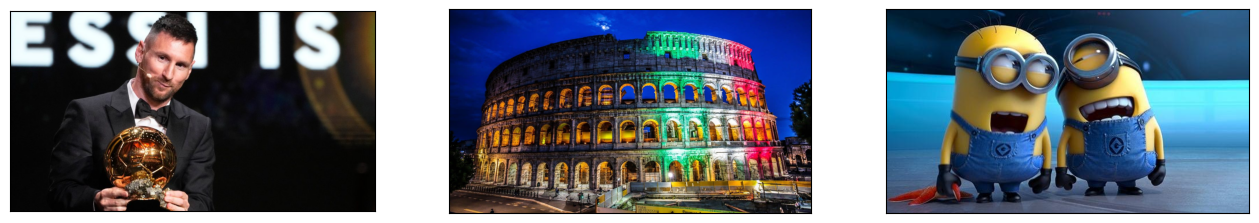

In [ ]:
import matplotlib.pyplot as plt
from llama_index.response.notebook_utils import display_image_uris

image_paths = [str(img_doc.image_path) for img_doc in image_documents]
display_image_uris(image_paths)

## Provide various prompts to test different Multi Modal LLMs

In [ ]:
from llama_index.multi_modal_llms import ReplicateMultiModal
from llama_index.multi_modal_llms.replicate_multi_modal import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

prompts = [
    "what is shown in this image?",
    "how many people are shown in the image?",
    "is there anything unusual in the image?",
]

## Generate Image Reasoning from different LLMs with different prompts for different images

In [ ]:
res = []
for prompt_idx, prompt in enumerate(prompts):
    for image_idx, image_doc in enumerate(image_documents):
        for llm_idx, llm_model in enumerate(REPLICATE_MULTI_MODAL_LLM_MODELS):
            try:
                ## Initialize the MultiModal LLM model
                multi_modal_llm = ReplicateMultiModal(
                    model=REPLICATE_MULTI_MODAL_LLM_MODELS[llm_model],
                    max_new_tokens=100,
                    temperature=0.1,
                    num_input_files=1,
                    top_p=0.9,
                    num_beams=1,
                    repetition_penalty=1,
                )

                mm_resp = multi_modal_llm.complete(
                    prompt=prompt,
                    image_documents=[image_doc],
                )
            except Exception as e:
                print(
                    f"Error with LLM model inference with prompt {prompt}, image {image_idx}, and MM model {llm_model}"
                )
                print("Inference Failed due to: ", e)
                continue
            res.append(
                {
                    "model": llm_model,
                    "prompt": prompt,
                    "response": mm_resp,
                    "image": str(image_doc.image_path),
                }
            )

## Display Sampled Responses from Multi-Modal LLMs 

In [ ]:
from IPython.display import display
import pandas as pd

pd.options.display.max_colwidth = None
df = pd.DataFrame(res)
display(df[:5])

,model,prompt,response,image
0,llava-13b,what is shown in this image?,"The image shows a man holding a gold trophy, possibly a soccer trophy, while wearing a suit and tie.",test_images/0.png
1,fuyu-8b,what is shown in this image?, The image shows a man wearing a suit and holding a golden ball trophy.,test_images/0.png
2,minigpt-4,what is shown in this image?,The image shows a man in a black suit and tie holding a golden trophy.,test_images/0.png
3,llava-13b,what is shown in this image?,"The image shows a large, illuminated building, which is the Colosseum in Rome, Italy. The building is lit up at night, and the lights create a beautiful and dramatic effect.",test_images/1.png
4,fuyu-8b,what is shown in this image?," The image showcases a city street at night, with colorful lights illuminating the scene. The street is lined with buildings, including a prominent Roman-style amphitheater.",test_images/1.png


## Human Label the Correctness and Relevance of the Multi-Modal LLM Reasoning Results
Note that Human Lable could have some bias/subjectivity when label relevance and correctness.

We label the Correctness and Relevance scores between [1, 5]

* 5: perfectly answer the question
* 4: somehow answer the question 
* 3: partly answer the question
* 2: answer the question with wrong answer
* 1: no answer or `hallucination`


| Model     | Prompt/Question                         | Model Reasoning Results                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | Correctness and relevance [1,5] | image             |
| --------- | --------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------- | ----------------- |
| llava-13b | what is shown in this image?            | The image shows a man holding a trophy, which appears to be a gold soccer ball. He is dressed in a suit and tie, and he is smiling as he holds the trophy.                                                                                                                                                                                                                                                                                                                                                                 | 4                                                                                               | test_images/0.png |
| fuyu-8b   | what is shown in this image?            |  The image shows a man wearing a suit and holding a golden ball trophy.                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 4                                                                                               | test_images/0.png |
| minigpt-4 | what is shown in this image?            | The image shows a man in a black suit and tie holding a golden trophy.                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 4                                                                                               | test_images/0.png |
| llava-13b | what is shown in this image?            | The image shows a large, illuminated building, likely a historical monument or a famous landmark, at night. The building is lit up with colored lights, creating a visually striking scene.                                                                                                                                                                                                                                                                                                                                | 4                                                                                               | test_images/1.png |
| fuyu-8b   | what is shown in this image?            |  The image showcases a city street at night, with colorful lights illuminating the scene. The street is lined with buildings, including a prominent Roman-style amphitheater.                                                                                                                                                                                                                                                                                                                                             | 4                                                                                               | test_images/1.png |
| minigpt-4 | what is shown in this image?            | The image shows the Colosseum, a large amphitheater in Rome, Italy. It is one of the most famous landmarks in the city and is a popular tourist attraction.                                                                                                                                                                                                                                                                                                                                                                | 5                                                                                               | test_images/1.png |
| llava-13b | what is shown in this image?            | The image shows two animated minion characters from the movie "Despicable Me" standing next to each other.                                                                                                                                                                                                                                                                                                                                                                                                                 | 5                                                                                               | test_images/2.png |
| fuyu-8b   | what is shown in this image?            |  The image features two minion figures, one wearing overalls and the other wearing goggles. They are standing next to each other, possibly engaged in conversation or posing for a photo.                                                                                                                                                                                                                                                                                                                                 | 5                                                                                               | test_images/2.png |
| minigpt-4 | what is shown in this image?            | The image shows two minions, one with a yellow overalls and the other with a blue overalls, both wearing sunglasses and standing next to each other.                                                                                                                                                                                                                                                                                                                                                                       | 4                                                                                               | test_images/2.png |
| llava-13b | how many people are shown in the image? | There is only one person shown in the image, a man holding a trophy.                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 5                                                                                               | test_images/0.png |
| fuyu-8b   | how many people are shown in the image? |  In the image, there is a man wearing a suit and holding a golden ball or trophy.                                                                                                                                                                                                                                                                                                                                                                                                                                         | 5                                                                                               | test_images/0.png |
| minigpt-4 | how many people are shown in the image? | I'm sorry, but I cannot see the image you provided. Can you please provide the image again?                                                                                                                                                                                                                                                                                                                                                                                                                                | NA                                                                                              | test_images/0.png |
| llava-13b | how many people are shown in the image? | There are two people shown in the image.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 1                                                                                               | test_images/1.png |
| fuyu-8b   | how many people are shown in the image? |  The image showcases a city street at night, with colorful lights illuminating the scene. The street is lined with buildings, including a prominent Roman-style amphitheater. \\n\\nThere are several people walking along the street, some carrying handbags. A few benches can be seen along the sidewalk, providing a place for pedestrians to rest. The atmosphere is lively, with people going about their daily activities.                                                                                         | 4                                                                                               | test_images/1.png |
| minigpt-4 | how many people are shown in the image? | I'm sorry, but I cannot see the image you provided. Can you please provide more information or a different image?                                                                                                                                                                                                                                                                                                                                                                                                          | NA                                                                                              | test_images/1.png |
| llava-13b | how many people are shown in the image? | There are two people shown in the image.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 4                                                                                               | test_images/2.png |
| fuyu-8b   | how many people are shown in the image? |  There are two people shown in the image.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 4                                                                                               | test_images/2.png |
| minigpt-4 | how many people are shown in the image? | There are two minions in the image.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 5                                                                                               | test_images/2.png |
| llava-13b | is there anything unusual in the image? | Yes, there is an unusual element in the image. The man is holding a gold trophy, which is not uncommon. However, he is also holding a microphone, which is an unusual combination. Typically, a person holding a microphone would be a speaker or an announcer, while a trophy is usually associated with an award or achievement. The combination of the microphone and the trophy suggests that the man might be a presenter or an announcer who is also receiving an award or acknowledging someone else's achievement. | 4                                                                                               | test_images/0.png |
| fuyu-8b   | is there anything unusual in the image? |  Yes, there is something unusual in the image, as there is a golden ball or trophy being held by a man wearing a suit. This is unusual because typically, sports balls or trophies are associated with competitions or achievements, rather than being worn by a person in a suit. The man holding the golden ball or trophy is wearing a suit, which adds to the peculiarity of the scene.                                                                                                                               | 3                                                                                               | test_images/0.png |
| minigpt-4 | is there anything unusual in the image? | The image shows a man in a black suit and tie holding a golden trophy. The trophy has a design on it that looks like a soccer ball. The man is smiling and appears to be happy.                                                                                                                                                                                                                                                                                                                                            | 3                                                                                               | test_images/0.png |
| llava-13b | is there anything unusual in the image? | Yes, there is an unusual aspect in the image. The Colosseum, a famous ancient Roman amphitheater, is lit up with colored lights, which is not a common sight. This illumination adds a unique and vibrant touch to the otherwise historical and majestic structure.                                                                                                                                                                                                                                                        | 4                                                                                               | test_images/1.png |
| fuyu-8b   | is there anything unusual in the image? |  Yes, the image features an unusual scene, as multiple people are walking around the colossal structure, which is an old Roman amphitheater. The amphitheater is illuminated with colorful lights, giving it a vibrant and lively atmosphere.                                                                                                                                                                                                                                                                             | 3                                                                                               | test_images/1.png |
| minigpt-4 | is there anything unusual in the image? | The image shows the Colosseum, a large amphitheater in Rome, Italy. It is a well known landmark and tourist attraction.                                                                                                                                                                                                                                                                                                                                                                                                    | 2                                                                                               | test_images/1.png |
| llava-13b | is there anything unusual in the image? | Yes, there is something unusual in the image. The two cartoon minions are standing next to each other, but one of them has a tooth missing. This is an unusual detail, as it is not common for animated characters to have imperfections like missing teeth. The missing tooth adds a unique and interesting aspect to the image, making it stand out from typical animated scenes.                                                                                                                                        | 3                                                                                               | test_images/2.png |
| fuyu-8b   | is there anything unusual in the image? |  Yes, there is an unusual aspect of the image, as there are two minions dressed in overalls, wearing goggles, and standing next to each other. This unusual combination is not typical, as minions are typically associated with their popular animation and movie franchises. The minions' overalls, goggles, and overalls-wearing, combined with the goggles they are wearing, adds to the peculiarity of the scene.                                                                                                    | 2                                                                                               | test_images/2.png |
| minigpt-4 | is there anything unusual in the image? | The image appears to be a cartoon character with overalls and a yellow shirt. The character is smiling and has a blue hat on its head. There is nothing unusual in the image.                                                                                                                                                                                                                                                                                                                                              | 5                                                                                               | test_images/2.png |

## Summary of preliminary findings with evaluated Multi-Modal Models

First, the purpose of this notework is to show how to leverage Replicate for serving different Multi-Modal LLMs for image reasoning tasks. There are some limitations with such comparison:

* We compared and evaluated LLaVa-13B, Fuyu-8B, and MiniGPT-4 for some simple and limited tasks/prompts. 
* Note that `the hyperparameters for different models are the same in the example`. The power of hyperparamters tuning could be significant for the quality MM LLMs models.
* Human evaluation could have some Bias/Subjectivity/Noise


Some preliminary findings:
* `MiniGPT-4` sometimes can yield a more accurate answer like `There are two minions in the image.` instead of `There are two people shown in the image.` from `LlaVa` or `Fuyu-8B`. Another example is that `MiniGPT-4` answers `Colosseum` directly for the question `what is it in the image` for the Italy Colosseum image.
* `MiniGPT-4` failed to give results for two prompts. It answers `I'm sorry, but I cannot see the image you provided.` But it can answer other questions for the same images. Not sure it is an issue of Replicate inference or MiniGPT-4 model itself
* `Fuyu-8B` and `LlaVa-13B` usually yield longer verbose answers to the question with more context to support.
* `Llava-13B` and `Fuyu-8B` sometimes yield slightly higher `hallucination` espeically for the question `is there anything unusual in the image?`


## Replicate Stream Complete, Async Complete, Async Stream Complete Mode

### Init Fuyu-8B Model

In [ ]:
multi_modal_llm = ReplicateMultiModal(
    model=REPLICATE_MULTI_MODAL_LLM_MODELS["fuyu-8b"],
    max_new_tokens=100,
    temperature=0.1,
    num_input_files=1,
    top_p=0.9,
    num_beams=1,
    repetition_penalty=1,
)

### Using async stream complete

In [ ]:
resp = await multi_modal_llm.astream_complete(
    prompt="tell me about this image",
    image_documents=[image_documents[0]],
)

In [ ]:
async for delta in resp:
    print(delta.delta, end="")

 The image features a man wearing a suit and tie, standing in front of a stage with a backdrop. He is holding a golden ball trophy, possibly an award, in his hands. The man appears to be posing for a photo, possibly celebrating his achievement or receiving an award.

In the background, there are multiple people visible, possibly attending or participating in the event. The backdrop appears to be a large screen, possibly displaying information about the event or ceremony.

### Using async complete

In [ ]:
resp = await multi_modal_llm.acomplete(
    prompt="tell me about this image",
    image_documents=[image_documents[0]],
)

In [ ]:
print(resp)

 The image features a man wearing a suit and tie, standing in front of a stage with a backdrop. He is holding a golden ball trophy, possibly an award, in his hands. The man appears to be posing for a photo, possibly celebrating his achievement or receiving an award.

In the background, there are multiple people visible, possibly attending or participating in the event. The backdrop appears to be a large screen, possibly displaying information about the event or ceremony.


### Using stream complete

In [ ]:
resp = multi_modal_llm.stream_complete(
    prompt="tell me about this image",
    image_documents=[image_documents[0]],
)

In [ ]:
for delta in resp:
    print(delta.delta, end="")

 The image features a man wearing a suit and tie, standing in front of a stage with a backdrop. He is holding a golden ball trophy, possibly an award, in his hands. The man appears to be posing for a photo, possibly celebrating his achievement or receiving an award.

In the background, there are multiple people visible, possibly attending or participating in the event. The backdrop appears to be a large screen, possibly displaying information about the event or ceremony.